In [1]:
# Project #1 Juypter Notebook
# Created by Melinda Eudy, Cameron Farquhar, Markita Francis, Luis Rojas, Kelly Rose
# Project : 2019 Crime Data Used from several resources ---UCR Crime Rates by County, US Census, and 

In [53]:
# Dependencies and Setup *******Review before final presentation and remove what is not needed*********
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
import scipy.stats as st
from datetime import date
from functools import reduce
import json
import ctypes  # An included library with Python install.
import datetime

# Import API key
#from config import apikey

In [54]:
# Part 1 - open UCR Crime Rates by County.csv file
#----------open 37059-Codebook County Codes.csv file and merge into first file to obtain County Names 
UCR_Crime = "Resources/UCR_Crime_Rates_by_County.csv"

# Read file and store in Pandas data frame
UCR_Crime_df = pd.read_csv(UCR_Crime)
UCR_Crime_df.head()
#UCR_Crime_df.count() ----all columns had same count

,STUDYNO,EDITION,PART,IDNO,FIPS_ST,FIPS_CTY,SPOPARST,SPOPCRIM,CPOPCRIM,AG_ARRST,...,SVIOL,SPROPERTY,SMURDER,SRAPE,SROBBERY,SAGASSLT,SBURGLRY,SLARCENY,SMVTHEFT,SARSON
0,9999,1,8,1,1,1,4863300,4816193,54499,3,...,0,0,0,0,0,0,0,0,0,0
1,9999,1,8,2,1,3,4863300,4816193,207584,14,...,0,0,0,0,0,0,0,0,0,0
2,9999,1,8,3,1,5,4863300,4816193,25778,5,...,0,0,0,0,0,0,0,0,0,0
3,9999,1,8,4,1,7,4863300,4816193,22474,4,...,0,0,0,0,0,0,0,0,0,0
4,9999,1,8,5,1,9,4863300,4816193,57565,6,...,0,0,0,0,0,0,0,0,0,0


In [55]:
# FIPS-ST is the first number of the Code, FIPS_City is the last three numbers of the code.
#-----Make FIPS_City three digits wide (adding zeros in front) and combine the two columns
UCR_Crime_df["FIPS_ST"] = UCR_Crime_df["FIPS_ST"].apply(str)
UCR_Crime_df["FIPS_CTY"] = UCR_Crime_df["FIPS_CTY"].apply(str)
UCR_Crime_df["FIPS_CTY"] = UCR_Crime_df["FIPS_CTY"].apply(lambda x: x.zfill(3))
UCR_Crime_df["CODE"] = UCR_Crime_df[["FIPS_ST", "FIPS_CTY"]].agg("".join, axis=1)
UCR_Crime_df.head()

,STUDYNO,EDITION,PART,IDNO,FIPS_ST,FIPS_CTY,SPOPARST,SPOPCRIM,CPOPCRIM,AG_ARRST,...,SPROPERTY,SMURDER,SRAPE,SROBBERY,SAGASSLT,SBURGLRY,SLARCENY,SMVTHEFT,SARSON,CODE
0,9999,1,8,1,1,001,4863300,4816193,54499,3,...,0,0,0,0,0,0,0,0,0,1001
1,9999,1,8,2,1,003,4863300,4816193,207584,14,...,0,0,0,0,0,0,0,0,0,1003
2,9999,1,8,3,1,005,4863300,4816193,25778,5,...,0,0,0,0,0,0,0,0,0,1005
3,9999,1,8,4,1,007,4863300,4816193,22474,4,...,0,0,0,0,0,0,0,0,0,1007
4,9999,1,8,5,1,009,4863300,4816193,57565,6,...,0,0,0,0,0,0,0,0,0,1009


In [56]:
UCR_Crime_df.columns

Index(['STUDYNO', 'EDITION', 'PART', 'IDNO', 'FIPS_ST', 'FIPS_CTY', 'SPOPARST',
       'SPOPCRIM', 'CPOPCRIM', 'AG_ARRST', 'AG_OFF', 'COVIND', 'SVIOL',
       'SPROPERTY', 'SMURDER', 'SRAPE', 'SROBBERY', 'SAGASSLT', 'SBURGLRY',
       'SLARCENY', 'SMVTHEFT', 'SARSON', 'CODE'],
      dtype='object')

In [57]:
# Finalize file for merging
#-----remove columns: STUDYNO, EDITION, PART, FLIPS_ST, FLIPS_CTY
#-----move Code to the front of the file - ensure that it is a int64.
UCR_Crime_df.drop(columns = ["STUDYNO", "EDITION", "PART", "FIPS_ST", "FIPS_CTY"], inplace = True)
UCR_Crime_df["CODE"] = UCR_Crime_df["CODE"].apply("int64")
pd.set_option("precision",0)
collist = UCR_Crime_df.columns.tolist()
collist.insert(0, collist.pop(collist.index("CODE")))
UCR_Crime_df = UCR_Crime_df.reindex(columns = collist)
UCR_Crime_df.head()

,CODE,IDNO,SPOPARST,SPOPCRIM,CPOPCRIM,AG_ARRST,AG_OFF,COVIND,SVIOL,SPROPERTY,SMURDER,SRAPE,SROBBERY,SAGASSLT,SBURGLRY,SLARCENY,SMVTHEFT,SARSON
0,1001,1,4863300,4816193,54499,3,3,100,0,0,0,0,0,0,0,0,0,0
1,1003,2,4863300,4816193,207584,14,14,100,0,0,0,0,0,0,0,0,0,0
2,1005,3,4863300,4816193,25778,5,4,94,0,0,0,0,0,0,0,0,0,0
3,1007,4,4863300,4816193,22474,4,5,96,0,0,0,0,0,0,0,0,0,0
4,1009,5,4863300,4816193,57565,6,6,98,0,0,0,0,0,0,0,0,0,0


In [58]:
UCR_Codes = "Resources/Codebook_County_Codes.csv"

# Read file and store in Pandas data frame
UCR_Codes_df = pd.read_csv(UCR_Codes)
#UCR_Codes_df.count()   --- all columns had the same count
UCR_Codes_df.head()

,State,Code,County,Unnamed: 3,Unnamed: 4,Unnamed: 5
0,Alabama,1001,Autauga,NaN,NaN,NaN
1,Alabama,1003,Baldwin,NaN,NaN,NaN
2,Alabama,1005,Barbour,NaN,NaN,NaN
3,Alabama,1007,Bibb,NaN,NaN,NaN
4,Alabama,1009,Blount,NaN,NaN,NaN


In [59]:
# Before mergining data:
# ------Remove Unnamed:3 - Unnamed:5
# ------Remove decimal in Code
#-------Rename Code to CODE
UCR_Codes_df.drop(columns = ["Unnamed: 3", "Unnamed: 4", "Unnamed: 5"], inplace = True)
UCR_Codes_df.rename(columns={"Code":"CODE", "State":"STATE", "County":"COUNTY"}, inplace = True)
UCR_Codes_df["CODE"] = UCR_Codes_df["CODE"].apply("int64")
pd.set_option("precision",0)
UCR_Codes_df.head(15)

,STATE,CODE,COUNTY
0,Alabama,1001,Autauga
1,Alabama,1003,Baldwin
2,Alabama,1005,Barbour
3,Alabama,1007,Bibb
4,Alabama,1009,Blount
5,Alabama,1011,Bullock
6,Alabama,1013,Butler
7,Alabama,1015,Calhoun
8,Alabama,1017,Chambers
9,Alabama,1019,Cherokee


In [60]:
# Merge Codebook_County_Codes.csv into UCR_Crime_Rates_by_County.csv
merged_UCR_Crime_df = pd.merge(UCR_Codes_df, UCR_Crime_df,on="CODE")
merged_UCR_Crime_df.head(15)
#merged_UCR_Crime_df.dtypes

,STATE,CODE,COUNTY,IDNO,SPOPARST,SPOPCRIM,CPOPCRIM,AG_ARRST,AG_OFF,COVIND,SVIOL,SPROPERTY,SMURDER,SRAPE,SROBBERY,SAGASSLT,SBURGLRY,SLARCENY,SMVTHEFT,SARSON
0,Alabama,1001,Autauga,1,4863300,4816193,54499,3,3,100,0,0,0,0,0,0,0,0,0,0
1,Alabama,1003,Baldwin,2,4863300,4816193,207584,14,14,100,0,0,0,0,0,0,0,0,0,0
2,Alabama,1005,Barbour,3,4863300,4816193,25778,5,4,94,0,0,0,0,0,0,0,0,0,0
3,Alabama,1007,Bibb,4,4863300,4816193,22474,4,5,96,0,0,0,0,0,0,0,0,0,0
4,Alabama,1009,Blount,5,4863300,4816193,57565,6,6,98,0,0,0,0,0,0,0,0,0,0
5,Alabama,1011,Bullock,6,4863300,4816193,10634,2,2,95,0,0,0,0,0,0,0,0,0,0
6,Alabama,1013,Butler,7,4863300,4816193,19952,4,4,97,0,0,0,0,0,0,0,0,0,0
7,Alabama,1015,Calhoun,8,4863300,4816193,114022,9,10,100,0,0,0,0,0,0,0,0,0,0
8,Alabama,1017,Chambers,9,4863300,4816193,34047,4,4,98,0,0,0,0,0,0,0,0,0,0
9,Alabama,1019,Cherokee,10,4863300,4816193,25774,4,5,99,0,0,0,0,0,0,0,0,0,0


In [61]:
# Bring in data from the US census per couounty
# adding median income per county
response = requests.get("https://api.census.gov/data/2019/acs/acs1?get=NAME,B06011_001E&for=county:*").json()
# locate the first row and make it the column name and then drop row 0
income_df = pd.DataFrame(response)
income_df.columns = income_df.iloc[0]
income_df = income_df.drop([1])

# delete and null info and reset the index
income_df = income_df.dropna(how='any')
income_df.reset_index()

#replace the integer column names with values in row 0
income_df.columns = income_df.iloc[0]
income_df = income_df.drop([0])
income_df.reset_index()
income_df.head(15)

,NAME,B06011_001E,state,county
2,"Calhoun County, Alabama",24513,01,015
3,"Cullman County, Alabama",25523,01,043
4,"DeKalb County, Alabama",22076,01,049
5,"Elmore County, Alabama",31124,01,051
6,"Etowah County, Alabama",23297,01,055
7,"Houston County, Alabama",26035,01,069
8,"Jefferson County, Alabama",30732,01,073
9,"Lauderdale County, Alabama",25048,01,077
10,"Lee County, Alabama",27057,01,081
11,"Limestone County, Alabama",29369,01,083


In [62]:
# create new columns for County and State
# ----Remove Columns: NAME, state, county
#-----Change column names to match merged UCR Crime data
#-----Remove word "County" in County name
income_df['County Name'] = income_df['NAME'].str.split(', ').apply(lambda x: x[0])
income_df['State Name'] = income_df['NAME'].str.split(', ').apply(lambda x: x[-1])
income_df['County Name'] = income_df['NAME'].str.split(' ').apply(lambda x: x[0])
income_df.drop(columns = ["NAME", "state", "county"], inplace = True)
income_df.rename(columns={"County Name":"COUNTY", "State Name":"STATE", "B06011_001E":"MEDIAN INCOME"}, inplace = True)
income_df.head
#income_df.dtypes

<bound method NDFrame.head of 0   MEDIAN INCOME     COUNTY      STATE
2           24513    Calhoun    Alabama
3           25523    Cullman    Alabama
4           22076     DeKalb    Alabama
5           31124     Elmore    Alabama
6           23297     Etowah    Alabama
..            ...        ...        ...
822         42434   Waukesha  Wisconsin
823         32222  Winnebago  Wisconsin
824         31040       Wood  Wisconsin
825         36805    Laramie    Wyoming
826         34223    Natrona    Wyoming

[825 rows x 3 columns]>

In [63]:
# Merge Census Median Income into UCR_Crime_Rates_by_County.csv
# Move Median Income to front of chart
Crime_df = pd.merge(merged_UCR_Crime_df, income_df, on=["STATE", "COUNTY"], how="left" )
collist = Crime_df.columns.tolist()
collist.insert(4, collist.pop(collist.index("MEDIAN INCOME")))
Crime_df = Crime_df.reindex(columns = collist)

# delete and null info and reset the index
Crime_df = Crime_df.dropna(how='any')
Crime_df.reset_index
Crime_df.head(15)

,STATE,CODE,COUNTY,IDNO,MEDIAN INCOME,SPOPARST,SPOPCRIM,CPOPCRIM,AG_ARRST,AG_OFF,...,SVIOL,SPROPERTY,SMURDER,SRAPE,SROBBERY,SAGASSLT,SBURGLRY,SLARCENY,SMVTHEFT,SARSON
7,Alabama,1015,Calhoun,8,24513,4863300,4816193,114022,9,10,...,0,0,0,0,0,0,0,0,0,0
21,Alabama,1043,Cullman,22,25523,4863300,4816193,82120,4,5,...,0,0,0,0,0,0,0,0,0,0
25,Alabama,1051,Elmore,26,31124,4863300,4816193,81680,7,7,...,0,0,0,0,0,0,0,0,0,0
27,Alabama,1055,Etowah,28,23297,4863300,4816193,100963,11,10,...,0,0,0,0,0,0,0,0,0,0
34,Alabama,1069,Houston,35,26035,4863300,4816193,104082,9,8,...,0,0,0,0,0,0,0,0,0,0
36,Alabama,1073,Jefferson,37,30732,4863300,4816193,659241,32,32,...,0,0,0,0,0,0,0,0,0,0
38,Alabama,1077,Lauderdale,39,25048,4863300,4816193,92068,8,7,...,0,0,0,0,0,0,0,0,0,0
40,Alabama,1081,Lee,41,27057,4863300,4816193,160071,3,5,...,0,0,0,0,0,0,0,0,0,0
41,Alabama,1083,Limestone,42,29369,4863300,4816193,93243,3,6,...,0,0,0,0,0,0,0,0,0,0
44,Alabama,1089,Madison,45,34885,4863300,4816193,355730,9,8,...,0,0,0,0,0,0,0,0,0,0


In [64]:
# Bring in data from the US census per county
#------population density per county
#------median income per county
response = requests.get(f'https://api.census.gov/data/2019/pep/population?get=DENSITY,POP,NAME&for=county:*').json()

# locate the first row and make it the column name and then drop row 0
county_dens_df = pd.DataFrame(response)
county_dens_df.columns = county_dens_df.iloc[0]
county_dens_df = county_dens_df.drop([0])

# delete and null info and reset the index
county_dens_df = county_dens_df.dropna(how='any')
county_dens_df.reset_index()
county_dens_df.head(15)

,DENSITY,POP,NAME,state,county
1,1.22086927860000,4198,"Hidalgo County, New Mexico",35,023
2,14555.93898300000000,672391,"Hudson County, New Jersey",34,017
3,290.70129177000000,124371,"Hunterdon County, New Jersey",34,019
4,1067.00355890000000,491845,"Morris County, New Jersey",34,027
5,13.09323114300000,71367,"McKinley County, New Mexico",35,031
6,39.55353872600000,146748,"Sandoval County, New Mexico",35,043
7,6.81560169160000,26998,"Grant County, New Mexico",35,017
8,34.82999005900000,48954,"Curry County, New Mexico",35,009
9,13.99788624200000,58460,"Eddy County, New Mexico",35,015
10,2.34704810570000,4521,"Mora County, New Mexico",35,033


In [65]:
# create new columns for County and State
# ----Remove Columns: NAME, state, county
#-----Change column names to match merged UCR Crime data
#-----Remove word "County" in County name
county_dens_df['County Name'] = county_dens_df['NAME'].str.split(', ').apply(lambda x: x[0])
county_dens_df['State Name'] = county_dens_df['NAME'].str.split(', ').apply(lambda x: x[-1])
county_dens_df['County Name'] = county_dens_df['NAME'].str.split(' ').apply(lambda x: x[0])
county_dens_df.drop(columns = ["NAME", "state", "county"], inplace = True)
county_dens_df.rename(columns={"County Name":"COUNTY", "State Name":"STATE"}, inplace = True)
county_dens_df.head()

,DENSITY,POP,COUNTY,STATE
1,1.22086927860000,4198,Hidalgo,New Mexico
2,14555.93898300000000,672391,Hudson,New Jersey
3,290.70129177000000,124371,Hunterdon,New Jersey
4,1067.00355890000000,491845,Morris,New Jersey
5,13.09323114300000,71367,McKinley,New Mexico


In [127]:
# Merge Codebook_County_Codes.csv into UCR_Crime_Rates_by_County.csv
# Move Density and Population to front of chart
merged_Crime_df = pd.merge(Crime_df, county_dens_df, on=["STATE", "COUNTY"], how = "left")
collist = merged_Crime_df.columns.tolist()
collist.insert(4, collist.pop(collist.index("DENSITY")))
collist.insert(5, collist.pop(collist.index("POP")))
merged_Crime_df = merged_Crime_df.reindex(columns = collist)

# delete and null info and reset the index
merged_Crime_df = merged_Crime_df.dropna(how='any')
merged_Crime_df.reset_index()
merged_Crime_df.head(50)

,STATE,CODE,COUNTY,IDNO,DENSITY,POP,MEDIAN INCOME,SPOPARST,SPOPCRIM,CPOPCRIM,...,SVIOL,SPROPERTY,SMURDER,SRAPE,SROBBERY,SAGASSLT,SBURGLRY,SLARCENY,SMVTHEFT,SARSON
0,Alabama,1015,Calhoun,8,187.50731202000000,113605,24513,4863300,4816193,114022,...,0,0,0,0,0,0,0,0,0,0
1,Alabama,1043,Cullman,22,114.01021653000000,83768,25523,4863300,4816193,82120,...,0,0,0,0,0,0,0,0,0,0
2,Alabama,1051,Elmore,26,131.31128980000000,81209,31124,4863300,4816193,81680,...,0,0,0,0,0,0,0,0,0,0
3,Alabama,1055,Etowah,28,191.12364467000000,102268,23297,4863300,4816193,100963,...,0,0,0,0,0,0,0,0,0,0
4,Alabama,1069,Houston,35,182.60057248000000,105882,26035,4863300,4816193,104082,...,0,0,0,0,0,0,0,0,0,0
5,Alabama,1073,Jefferson,37,592.55351575000000,658573,30732,4863300,4816193,659241,...,0,0,0,0,0,0,0,0,0,0
6,Alabama,1077,Lauderdale,39,138.81313278000000,92729,25048,4863300,4816193,92068,...,0,0,0,0,0,0,0,0,0,0
7,Alabama,1081,Lee,41,270.83432209000000,164542,27057,4863300,4816193,160071,...,0,0,0,0,0,0,0,0,0,0
8,Alabama,1083,Limestone,42,176.64798277000000,98915,29369,4863300,4816193,93243,...,0,0,0,0,0,0,0,0,0,0
9,Alabama,1089,Madison,45,465.21086205000000,372909,34885,4863300,4816193,355730,...,0,0,0,0,0,0,0,0,0,0


ConversionError: Failed to convert value(s) to axis units: <bound method Series.min of 242     10.05157672700000
373     10.20633119400000
660     10.40904089600000
370     10.64993377300000
715    100.30751685000000
              ...        
231     98.20217498700000
105    986.07766533000000
523     99.10578176300000
388     99.58504520100000
609     99.89025755100000
Name: DENSITY, Length: 734, dtype: object>

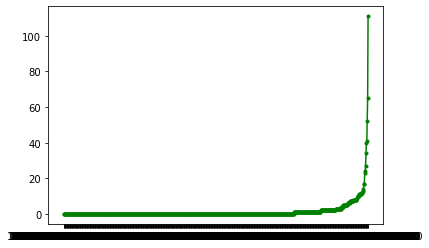

In [129]:
pop_sort = merged_Crime_df["DENSITY"].sort_values()
murd_sort = merged_Crime_df["SAGASSLT"].sort_values()

x_values = pop_sort
y_values = murd_sort

plt.plot(x_values, y_values, color='green', marker='.')

plt.xlim(x_values.min,x_values.max)
plt.ylim(y_values.min,y_values.max)

plt.show()

(-1000.0, 4639580.0)

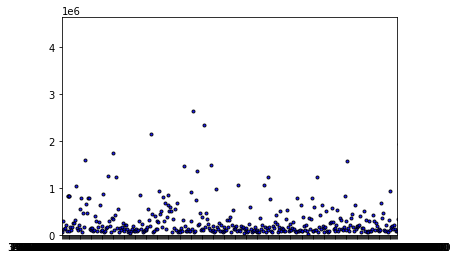

In [138]:
x_values = merged_Crime_df["DENSITY"]
y_values = merged_Crime_df["CPOPCRIM"]

# (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# regress_values = x_values * slope + intercept

# line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))

plt.scatter(x_values, y_values, marker=".", facecolors="blue", edgecolors="black", alpha=0.90)

# plt.grid(b=True, which='major', color='grey', linestyle='-', alpha=0.70)

# plt.annotate(line_eq,(0,-10), fontsize=15,color="red")

plt.xlim(x_values.min(),x_values.max())
plt.ylim(y_values.min()-1000,y_values.max()-500000)

# plt.title(f"City Latitude vs. Max Temperature ({curr_date})")
# plt.xlabel("Latitude")
# plt.ylabel("Max Temperature(F)")

# plt.grid(b=True, which='major', color='grey', linestyle='-', alpha=0.70)

# print(f'the r-value is: {rvalue**2}')

TypeError: can't multiply sequence by non-int of type 'float'

In [106]:
# density_hist = merged_Crime_df["DENSITY"]
# plt.hist(density_hist, bins = 10)
# plt.show()

0     707
1      21
2       3
10      1
6       1
4       1
Name: SMURDER, dtype: int64